# Вариант 1

Цель: Контроль дисперсии весов.

Разработайте архитектуру, которая будет за 5 слоев приводить тензор к размерности (1, 512, 1, 1).  
Условие: дисперсия весов третьего слоя должна быть в два раза больше, чем у второго и четвертого.  
Эксперимент: Проверьте влияние увеличенной дисперсии третьего слоя на распределение активаций после GAP и визуализируйте их гистограмму.

In [14]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

In [20]:
class VarianceControllNet(nn.Module):
    def __init__(self, change_variance_of_3rd_layer=1):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1), # 3 слой - для него будем увеличивать дисперсию
            nn.ReLU(),
            nn.Conv2d(256, 512, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1,1))
        )
        self._init_weights(change_variance_of_3rd_layer)

    def _init_weights(self, change_variance_of_3rd_layer):
            base_std = 1
            conv_layers = [m for m in self.net if isinstance(m, nn.Conv2d)]

            nn.init.normal_(conv_layers[0].weight, mean=0.0, std=base_std)
            nn.init.normal_(conv_layers[1].weight, mean=0.0, std=base_std)
            nn.init.normal_(conv_layers[2].weight, mean=0.0, std=base_std * change_variance_of_3rd_layer)
            nn.init.normal_(conv_layers[3].weight, mean=0.0, std=base_std)
            nn.init.normal_(conv_layers[4].weight, mean=0.0, std=base_std)

    def forward(self, x):
        return self.net(x)


In [21]:
model_base = VarianceControllNet()
model_double_var = VarianceControllNet(change_variance_of_3rd_layer=2 ** 0.5)
x = torch.randn(1, 3, 224, 224)

with torch.no_grad():
    out_base = model_base(x)
    out_double_var = model_double_var(x)

activations_base = out_base.view(out_base.size(0), -1).cpu().numpy().flatten()
activations_double_var = out_double_var.view(out_double_var.size(0), -1).cpu().numpy().flatten()

In [22]:
conv_layers_base = [m for m in model_base.net if isinstance(m, nn.Conv2d)]
conv_layers_double_var = [m for m in model_double_var.net if isinstance(m, nn.Conv2d)]

var2 = conv_layers_base[1].weight.var(unbiased=False)
var3 = conv_layers_base[2].weight.var(unbiased=False)
var4 = conv_layers_base[3].weight.var(unbiased=False)

print(var3 / var2, var3 / var4)

var2 = conv_layers_double_var[1].weight.var(unbiased=False)
var3 = conv_layers_double_var[2].weight.var(unbiased=False)
var4 = conv_layers_double_var[3].weight.var(unbiased=False)

print(var3 / var2, var3 / var4)

tensor(0.9912, grad_fn=<DivBackward0>) tensor(0.9998, grad_fn=<DivBackward0>)
tensor(2.0034, grad_fn=<DivBackward0>) tensor(2.0007, grad_fn=<DivBackward0>)


## Гистограмма 

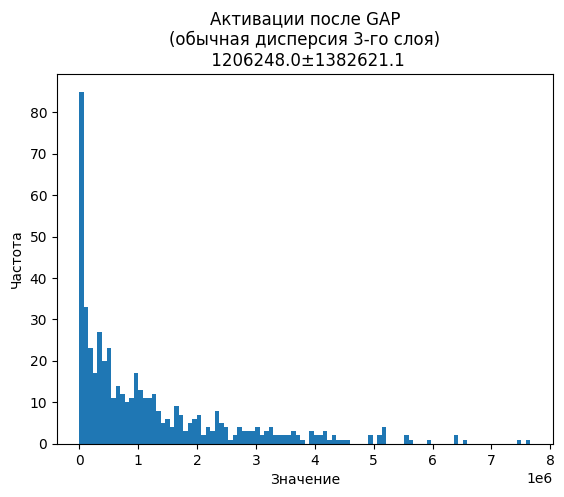

torch.Size([1, 512, 1, 1])

In [28]:
plt.figure()
plt.hist(activations_base, bins=100)
plt.title(f"Активации после GAP\n(обычная дисперсия 3-го слоя)\n {activations_base.mean():.1f}±{activations_base.std():.1f}")
plt.xlabel("Значение")
plt.ylabel("Частота")
plt.show()

out_base.shape

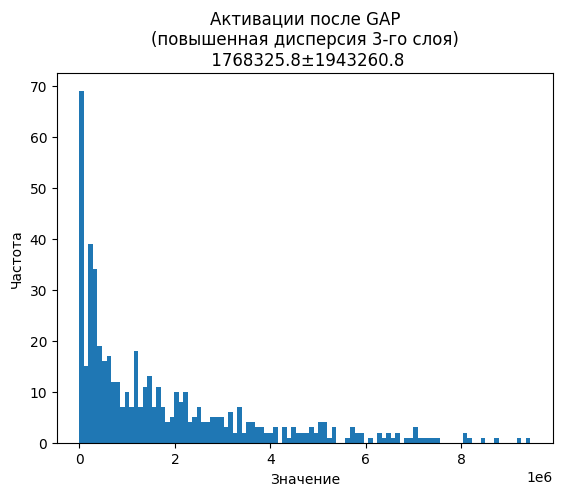

torch.Size([1, 512, 1, 1])

In [29]:
plt.figure()
plt.hist(activations_double_var, bins=100)
plt.title(f"Активации после GAP\n(повышенная дисперсия 3-го слоя)\n {activations_double_var.mean():.1f}±{activations_double_var.std():.1f}")
plt.xlabel("Значение")
plt.ylabel("Частота")
plt.show()

out_double_var.shape

## Выводы:

После анализа гистограмм активаций и вычисленных дисперсий весов свёрточных слоёв, можно сделать следующие выводы:
1. Увеличение дисперсии весов третьего свёрточного слоя привело к увеличению дисперсии активаций после GAP. По гистограммам видно, что активации модели с повышенной дисперсией имеют более широкий разброс значений.
2. Соотношение дисперсий весов между слоями изменилось в соответствии с заданным коэффициентом увеличения дисперсии третьего слоя. Это подтверждается вычисленными отношениями дисперсий весов между вторым, третьим и четвёртым слоями.